# Tile Projection of Environments: Reward Recovery

Our aim is to carry out RL tasks when rewards are delayed (aggregate, and anonymous), using linear function approximation.
To solve this problem, we aim to project both large discrete states and continuous states into basis vectors.


In this notebook, we explore using Tiling as representations of states.
Tiles are parametized, defining the dimension (# tiles on each side) and number of tilings.

More information can be found here: http://incompleteideas.net/tiles/tiles3.html

We use Tiles in the task of recovering rewards for state-actions.

In [1]:
import copy
import itertools
import math
import functools
from typing import Optional, Any

In [2]:
import gymnasium as gym
import numpy as np
import pandas as pd
from scipy import linalg
import gym_electric_motor as gem
from gym_electric_motor import reward_functions

In [3]:
from rlplg.environments import gridworld, redgreen

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt

## Tiling

In [5]:
"""
Tile Coding Software version 3.0beta
by Rich Sutton
based on a program created by Steph Schaeffer and others
External documentation and recommendations on the use of this code is available in the 
reinforcement learning textbook by Sutton and Barto, and on the web.
These need to be understood before this code is.

This software is for Python 3 or more.

This is an implementation of grid-style tile codings, based originally on
the UNH CMAC code (see http://www.ece.unh.edu/robots/cmac.htm), but by now highly changed. 
Here we provide a function, "tiles", that maps floating and integer
variables to a list of tiles, and a second function "tiles-wrap" that does the same while
wrapping some floats to provided widths (the lower wrap value is always 0).

The float variables will be gridded at unit intervals, so generalization
will be by approximately 1 in each direction, and any scaling will have 
to be done externally before calling tiles.

Num-tilings should be a power of 2, e.g., 16. To make the offsetting work properly, it should
also be greater than or equal to four times the number of floats.

The first argument is either an index hash table of a given size (created by (make-iht size)), 
an integer "size" (range of the indices from 0), or nil (for testing, indicating that the tile 
coordinates are to be returned without being converted to indices).
"""

basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval                        
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count(self):
        return len(self.dictionary)
    
    def fullp(self):
        return len(self.dictionary) >= self.size
    
    def getindex(self, obj, readonly=False):
        d = self.dictionary
        if obj in d:
            return d[obj]
        elif readonly:
            return None
        size = self.size
        count = self.count()
        if count >= size:
            # TODO: Fail
            if self.overfullCount==0: 
                print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if isinstance(m, IHT):
        return m.getindex(tuple(coordinates), readonly)
    if isinstance(m, int):
        return basehash(tuple(coordinates)) % m
    if m is None:
        return coordinates


def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [math.floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap (ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [math.floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in itertools.zip_longest(qfloats, wrapwidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles



## Random Data

First, we explore tiles using random 2D data, to understand the range of input and outputs, as well as adequate parameters for a given input space.

<Axes: >

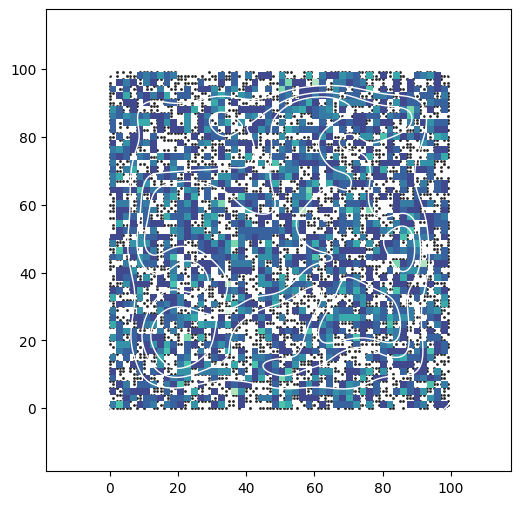

In [6]:
n = 10000
mean = [0, 0]
cov = [(2, .4), (.4, 2)]
# x, y = rng.multivariate_normal(mean, cov, n).T
rng = np.random.default_rng()
# x, y = rng.multivariate_normal(mean, cov, n).T
x = rng.integers(low=0, high=100, size=n)
y = rng.integers(low=0, high=100, size=n)

# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)

In [7]:
x, y

(array([ 7, 75, 70, ..., 91, 66, 79]), array([12, 34, 11, ..., 76, 48, 19]))

In [8]:
def pow2geq(lb):
    exp = 1
    while True:
        rs = np.power(2, exp)
        if rs >= lb:
            break
        exp += 1
    return rs

In [9]:
tiling_dim = 10
num_input_dims = 2
numTilings = pow2geq(num_input_dims * 4)
maxSize = tiling_dim * tiling_dim * numTilings
print("numTilings", numTilings)
print("maxsize", maxSize)
iht = IHT(maxSize)
minx, maxx = np.min(x), np.max(x)
miny, maxy = np.min(y), np.max(y)

def mytiles(x, y, numTilings: int):
    # scale values to be between [0, dim]
    return tiles(iht, numTilings, [(x - minx)/(maxx-minx) * tiling_dim,(y-miny)/(maxy-miny) * tiling_dim])

def mywrappedtiles(x, y, numTilings):
    return tileswrap(iht, numTilings, 
                     [(x - minx)/(maxx-minx) * tiling_dim,(y-miny)/(maxy-miny) * tiling_dim],
                     [tiling_dim, tiling_dim]
                    )
    
print("x",  minx, maxx)
print("y",  miny, maxy)
print("mytile", mytiles(1, 50, numTilings=numTilings))
print("mytile", mytiles(10, 24, numTilings=numTilings))
print("mytile", mywrappedtiles(76, 50, numTilings=numTilings))
print("mytile", mywrappedtiles(10, 24, numTilings=numTilings))

maxidx = 0
for i in range(0, 100):
    for j in range(0, 100):
        maxidx = np.max([maxidx] + mywrappedtiles(i, j, numTilings=numTilings))
        
print("maxidx", maxidx)

numTilings 8
maxsize 800
x 0 99
y 0 99
mytile [0, 1, 2, 3, 4, 5, 6, 7]
mytile [8, 9, 10, 11, 12, 13, 14, 15]
mytile [16, 17, 18, 19, 20, 21, 22, 23]
mytile [8, 9, 10, 24, 25, 26, 27, 28]
maxidx 799


## Reward Recovery

In [10]:
def solve_least_squares(
    matrix: np.ndarray, rhs: np.ndarray
) -> np.ndarray:
    try:
        solution, _, _, _ = linalg.lstsq(a=matrix, b=rhs, lapack_driver="gelsy")
        return solution  # type: ignore
    except linalg.LinAlgError as err:
        # the computation failed, likely due to the matix being unsuitable (no solution).
        raise ValueError("Failed to solve linear system") from err

In [11]:
def rmse(v_pred: np.ndarray, v_true: np.ndarray, axis: int):
    if np.shape(v_pred) != np.shape(v_true):
        raise ValueError(
            f"Tensors have different shapes: {np.shape(v_pred)} != {np.shape(v_true)}"
        )
    return np.sqrt(
        np.sum(np.power(v_pred - v_true, 2.0), axis=axis) / np.shape(v_pred)[axis]
    )

## Gym Env

In [12]:
def collection_traj_data(env, steps: int):
    obs, _ = env.reset()
    step = 0
    buffer = []
    while step < steps:
        action = env.action_space.sample()
        next_obs, rew, term, trunc, _,  = env.step(action)
        step += 1
        buffer.append((obs, action, rew))
        obs = next_obs
        if term or trunc:
            obs, _ = env.reset()
    return buffer

In [13]:
def tiling_proj(obs_min, obs_max, tiling_dim: int):
    # obs = np.stack([example[0] for example in buffer])
    assert isinstance(obs_min, np.ndarray)
    assert isinstance(obs_max, np.ndarray)
    wrapwidths = [tiling_dim] * np.size(obs_min)

    # num tilings should a power of 2
    # and at least 4 times greater than
    # the number of dimensions
    num_tilings = pow2geq(np.size(obs_min) * 4)
    max_size = (tiling_dim ** np.size(obs_min)) * num_tilings
    print("Num tilings", num_tilings, "\n", "Flat dim:", max_size)
    iht = IHT(max_size)    
    def mywrappedtiles(obs):
        obs_scaled_01 = (obs - obs_min) / (obs_max - obs_min)
        repr = np.zeros(shape=max_size)
        idx = tileswrap(
            iht, 
            num_tilings, 
            obs_scaled_01 * tiling_dim,
            wrapwidths
        )
        repr[idx] = 1
        return repr
    return mywrappedtiles

In [14]:
env = gym.make("MountainCar-v0")
proj_fn = tiling_proj(
        env.observation_space.low, 
        env.observation_space.high,
        tiling_dim=4
    )
obs, _ = env.reset()
print(obs)
print(proj_fn(obs))

Num tilings 8 
 Flat dim: 128
[-0.4886481  0.       ]
[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [15]:
vars(proj_fn)

{}

In [16]:
class Tiles:
    def __init__(
        self, dims_min: np.ndarray, dims_max: np.ndarray, 
        tiling_dim: int, num_tilings: Optional[int] = None
    ):
        assert isinstance(dims_min, np.ndarray)
        assert isinstance(dims_max, np.ndarray)
        self.dims_max = dims_max
        self.dims_min = dims_min
        self.tiling_dim = tiling_dim
        self.wrapwidths = [tiling_dim] * np.size(dims_min)
    
        # num tilings should a power of 2
        # and at least 4 times greater than
        # the number of dimensions
        self.num_tilings = num_tilings or pow2geq(np.size(dims_min) * 4)
        self.max_size = (tiling_dim ** np.size(dims_min)) * self.num_tilings
        print("Num tilings", self.num_tilings, "\n", "Flat dim:", self.max_size)
        self.iht = IHT(self.max_size)

    def __call__(self, xs):
        xs_scaled_01 = (xs - self.dims_min) / (self.dims_max - self.dims_min)
        repr = np.zeros(shape=self.max_size)
        idx = tileswrap(
            self.iht, 
            self.num_tilings, 
            xs_scaled_01 * self.tiling_dim,
            self.wrapwidths
        )
        repr[idx] = 1
        return repr    

In [17]:
env = gym.make("MountainCar-v0")
tile_fn = Tiles(
        env.observation_space.low,
        env.observation_space.high,
        tiling_dim=4
    )
obs, _ = env.reset()
print(obs)
print(tile_fn(obs))

Num tilings 8 
 Flat dim: 128
[-0.5315901  0.       ]
[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [18]:
vars(tile_fn)

{'dims_max': array([0.6 , 0.07], dtype=float32),
 'dims_min': array([-1.2 , -0.07], dtype=float32),
 'tiling_dim': 4,
 'wrapwidths': [4, 4],
 'num_tilings': 8,
 'max_size': 128,
 'iht': <__main__.IHT at 0x7f050d9201d0>}

In [19]:
def delay_reward_data(buffer, delay: int, sample_size: int):
    obs = np.stack([example[0] for example in buffer])
    action = np.stack([example[1] for example in buffer])
    reward = np.stack([example[2] for example in buffer])

    # repr: (m1,a1)(m2,a1)..
    mdim = obs.shape[1] * len(np.unique(action))
    num_components = obs.shape[1]

    # build samples
    mask = np.random.choice(len(obs), (sample_size, delay))
    delayed_obs = obs[mask] # batch x delay x dim
    delayed_act = action[mask]
    delayed_rew = np.sum(reward[mask], axis=1) # batch x delay -> batch    
    
    rhat_matrix = np.zeros(shape=(len(delayed_obs), mdim))
    
    for i in range(len(delayed_obs)):
        for j in range(delay):
            c = num_components*delayed_act[i][j]
            rhat_matrix[i,c:c+num_components] += delayed_obs[i][j]

    return rhat_matrix, delayed_rew

In [20]:
def proj_obs_to_rwest_vec(buffer, sample_size: int):
    obs = np.stack([example[0] for example in buffer])
    action = np.stack([example[1] for example in buffer])
    reward = np.stack([example[2] for example in buffer])
    
    # repr: (m1,a1)(m2,a1)..
    mdim = obs.shape[1] * len(np.unique(action))
    num_components = obs.shape[1]

    # build samples
    mask = np.random.choice(len(obs), sample_size)
    delayed_obs = obs[mask] # batch x dim
    delayed_act = action[mask] # batch
    delayed_rew = reward[mask] # batch
    
    rhat_matrix = np.zeros(shape=(len(delayed_obs), mdim))
    
    for i in range(len(delayed_obs)):
        c = num_components*delayed_act[i]
        rhat_matrix[i,c:c+num_components] += delayed_obs[i]
    return rhat_matrix, delayed_rew

In [21]:
def solve_rwe(env: gym.Env, num_steps: int, sample_size: int, delay: int):
    buffer = collection_traj_data(env, steps=num_steps)
    Xd, yd = delay_reward_data(buffer, delay=delay, sample_size=sample_size)
    return buffer, solve_least_squares(Xd, yd)

In [22]:
def rwe_scatterplot(v_pred, v_true):
    _, ax = plt.subplots(figsize=(6, 6))
    df = pd.DataFrame({
        "x": v_pred,
        "y": v_true,
        "size": np.abs(v_pred - v_true)
    })
    sns.scatterplot(
        df, x="x", y="y", size="size", hue="size", s=5, color=".15"
    )
    # sns.histplot(x=v_pred, y=v_true, bins=50, cmap="mako")
    # sns.kdeplot(x=v_pred, y=v_true, levels=5, color="w")
    ax.set_xlabel("yhat")
    ax.set_ylabel("ytrue")
    ax.set_title("Reward Estimation")

In [23]:
def hashtrick(xs, dim: int):
    ys = np.zeros(dim, dtype=np.int32)
    idx,  = np.where(xs == 1)
    for i in idx:
        ys[i % dim] += 1
    return ys

### Moutain Car

In [24]:
class MCObsWrapper(gym.ObservationWrapper):
    def __init__(self, env, tiling_dim: int, num_tilings: int = None):
        super().__init__(env)
        self.tiles = Tiles(
                env.observation_space.low,
                env.observation_space.high,
                tiling_dim=tiling_dim,
                num_tilings=num_tilings
            )
        self.observation_space = gym.spaces.Box(
            low=np.zeros(shape=self.tiles.max_size, dtype=np.int32), 
            high=np.ones(shape=self.tiles.max_size, dtype=np.int32)
        )

    def observation(self, obs):
        return self.tiles(obs)

In [25]:
mc_env = MCObsWrapper(gym.make("MountainCar-v0"), tiling_dim=4)
mc_buffer, mc_sol = solve_rwe(
    mc_env,
    num_steps=150_000, 
    sample_size=50_000,
    delay=2,
)

Num tilings 8 
 Flat dim: 128


In [26]:
len(mc_buffer)

150000

In [27]:
mc_buffer[0][0]

array([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [28]:
mc_env.tiles

In [29]:
mc_sol

array([-0.12043771,  0.03864081, -0.16509872, -0.11982939, -0.13916406,
       -0.1382048 , -0.19437242, -0.16153371, -0.12043771, -0.11982939,
       -0.13916406, -0.11982939, -0.1382048 , -0.1382048 , -0.1382048 ,
       -0.16509872, -0.11982939, -0.19437242, -0.19437242, -0.16153371,
       -0.16509872, -0.16509872,  0.03864081, -0.19437242,  0.03864081,
       -0.16153371, -0.13916406, -0.13916406, -0.13916406, -0.13916406,
       -0.12043771, -0.12043771, -0.12043771, -0.12043771,  0.03864081,
       -0.16153371,  0.03864081, -0.16153371, -0.16509872, -0.16153371,
        0.03864081,  0.03864081, -0.16153371,  0.        ,  0.        ,
       -0.1382048 , -0.16509872, -0.11982939, -0.11982939,  0.        ,
        0.        ,  0.        , -0.19437242,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [30]:
mc_eval_X, mc_eval_y = proj_obs_to_rwest_vec(mc_buffer, sample_size=10_000)

In [31]:
np.matmul(mc_eval_X, mc_sol)

array([-1., -1., -1., ..., -1., -1., -1.])

In [32]:
rmse(
    v_pred=np.matmul(mc_eval_X, mc_sol), 
    v_true=mc_eval_y,
    axis=0
)

2.526166056435852e-16

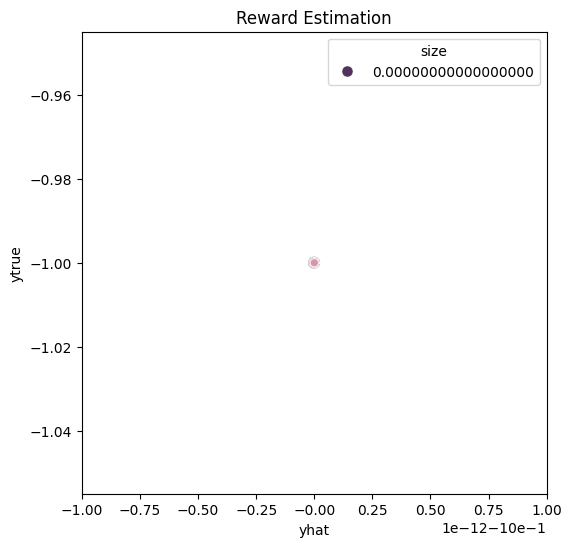

In [33]:
rwe_scatterplot(
    v_pred=np.matmul(mc_eval_X, mc_sol), 
    v_true=mc_eval_y
)

The estimation error is low on this environment, though the reward is a constant.

### Grid World (Different Rewards)

In [34]:
class GWObsWrapper(gym.ObservationWrapper):
    def __init__(self, env, tiling_dim: int, num_tilings: int = None):
        super().__init__(env)
        self.tiles = Tiles(
                np.array([0, 0], np.int32),
                np.array(
                    [env.observation_space["agent"][0].n, env.observation_space["agent"][1].n]
                ),
                tiling_dim=tiling_dim,
                num_tilings=num_tilings
            )
        self.observation_space = gym.spaces.Box(
            low=np.zeros(shape=self.tiles.max_size, dtype=np.int32), 
            high=np.ones(shape=self.tiles.max_size, dtype=np.int32)
        )

    def observation(self, obs):
        return self.tiles(obs["agent"])

In [35]:
size, cliffs, exits, start = gridworld.parse_grid_from_text(
    ["oooooooooooo", "oooooooooooo", "oooooooooooo", "sxxxxxxxxxxg"]
)
print(size, cliffs, exits, start)
gw_env = GWObsWrapper(
    gridworld.GridWorld(size, cliffs, exits, start),
    tiling_dim=8
)
gw_buffer, gw_sol = solve_rwe(
    gw_env,
    num_steps=150_000, 
    sample_size=50_000,
    delay=2,
)

(4, 12) [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10)] [(3, 11)] (3, 0)
Num tilings 8 
 Flat dim: 512


In [36]:
np.unique([ex[2] for ex in gw_buffer])

array([-100.,   -1.])

In [37]:
gw_sol

array([-0.22828797,  5.6997651 , -5.5576334 , ...,  0.        ,
        0.        ,  0.        ])

In [38]:
gw_env.tiles

In [39]:
gw_eval_X, gw_eval_y = proj_obs_to_rwest_vec(gw_buffer, sample_size=10_000)

In [40]:
np.unique(gw_eval_y)

array([-100.,   -1.])

In [41]:
gw_eval_X.shape, gw_eval_y.shape

((10000, 2048), (10000,))

In [42]:
np.unique(np.around(np.matmul(gw_eval_X, gw_sol), 2))

array([-100.,   -1.])

In [43]:
rmse(
    v_pred=np.matmul(gw_eval_X, gw_sol), 
    v_true=gw_eval_y,
    axis=0
)

1.3925318770330393e-14

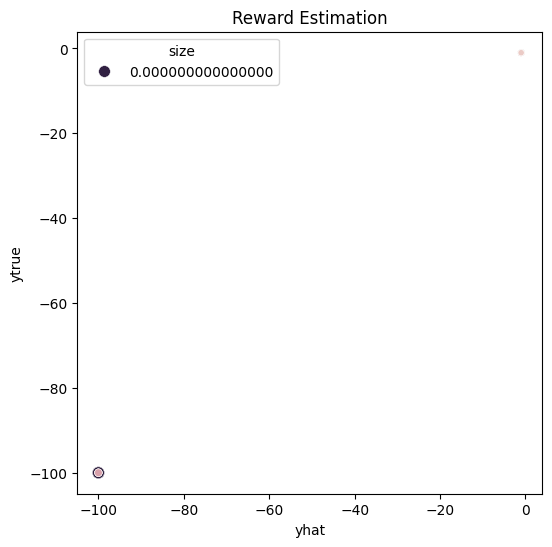

In [44]:
rwe_scatterplot(
    v_pred=np.matmul(gw_eval_X, gw_sol), 
    v_true=gw_eval_y
)

The error here is neligible, which is promising compare to Gaussian Mixture.

### RedGreen

In [45]:
class RGObsWrapper(gym.ObservationWrapper):
    def __init__(self, env, tiling_dim: int, num_tilings: int = None):
        super().__init__(env)
        self.tiles = Tiles(
                np.array([0], np.int32),
                np.array(
                    [env.observation_space["pos"].n]
                ),
                tiling_dim=tiling_dim,
                num_tilings=num_tilings
            )
        self.observation_space = gym.spaces.Box(
            low=np.zeros(shape=self.tiles.max_size, dtype=np.int32), 
            high=np.ones(shape=self.tiles.max_size, dtype=np.int32)
        )

    def observation(self, obs):
        return self.tiles(obs["pos"])

In [46]:
rg_env = RGObsWrapper(
    redgreen.RedGreenSeq(["red", "green", "red", "green", "wait", "green"]),
    tiling_dim=2
)
rg_buffer, rg_sol = solve_rwe(
    rg_env,
    num_steps=150_000, 
    sample_size=50_000,
    delay=2,
)

Num tilings 4 
 Flat dim: 8


In [47]:
rg_buffer[0][0]

array([1., 1., 1., 1., 0., 0., 0., 0.])

In [48]:
np.unique([np.around(ex[2], 2) for ex in rg_buffer])

array([-1.])

In [49]:
rg_env.tiles

In [50]:
rg_sol

array([-3.42190067, -0.5854992 ,  4.78584001, -1.77844014, -1.77844014,
        4.78584001, -0.5854992 , -3.42190067,  0.7025346 , -0.11527318,
        1.06741721, -2.65467863, -2.65467863,  1.06741721, -0.11527318,
        0.7025346 , -0.69003331, -2.58479563,  1.68720336,  0.58762558,
        0.58762558,  1.68720336, -2.58479563, -0.69003331])

In [51]:
rg_eval_X, rg_eval_y = proj_obs_to_rwest_vec(rg_buffer, sample_size=10_000)

In [52]:
rg_eval_X.shape, rg_eval_y.shape

((10000, 24), (10000,))

In [53]:
np.matmul(rg_eval_X, rg_sol)

array([-1., -1., -1., ..., -1., -1., -1.])

In [54]:
rmse(
    v_pred=np.matmul(rg_eval_X, rg_sol), 
    v_true=rg_eval_y,
    axis=0
)

1.4747623633517817e-15

Here, the results are also optimistic - tough, once again, the reward is a constant.

### Lunda Lander

In [55]:
class LLObsPreproc(gym.ObservationWrapper):
    """
    Transform state to correspond to 
    the input of the reward fn used
    by the environment.
    """
    def __init__(
        self, env
    ):
        super().__init__(env)
        self.prev_obs = None

    def observation(self, obs):
        # https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/box2d/lunar_lander.py#L639
        x1 = np.sqrt(obs[0] * obs[0] + obs[1] * obs[1])
        x2 = np.sqrt(obs[2] * obs[2] + obs[3] * obs[3])
        x3 = abs(obs[4])
        shaping = np.concatenate([[x1, x2, x3], obs[5:]])
        new_obs = copy.copy(shaping)
        if self.prev_obs is not None:
            new_obs -= self.prev_obs
        self.prev_obs = shaping
        return new_obs
        

In [56]:
class LLObsWrapper(gym.ObservationWrapper):
    def __init__(
        self, env, tiling_dim: int, num_tilings: int = None, hash_dim: Optional[int] = None
    ):
        super().__init__(env)
        self.hash_dim = hash_dim
        self.tiles = Tiles(
            # TODO: fix
            dims_min=env.observation_space.low[:4],
            dims_max=env.observation_space.high[:4],
            tiling_dim=tiling_dim,
            num_tilings=num_tilings
        )
        # TODO: hash dim
        self.observation_space = gym.spaces.Box(
            low=np.zeros(shape=self.tiles.max_size, dtype=np.int32), 
            high=np.ones(shape=self.tiles.max_size, dtype=np.int32)
        )
        self.prev_obs = None

    def observation(self, obs):
        xs = self.tiles(obs[:4])
        if self.hash_dim:
            xs = hashtrick(xs, dim=self.hash_dim)
        # return np.concatenate([obs, np.array([1])]) 
        return np.concatenate([obs[:4], obs[4:]])

In [57]:
lunar_env = LLObsWrapper(
    LLObsPreproc(gym.make("LunarLander-v3")), tiling_dim=4, hash_dim=128
)
lunar_buffer, lunar_sol = solve_rwe(
    lunar_env,
    num_steps=150_000, 
    sample_size=50_000,
    delay=2,
)

Num tilings 16 
 Flat dim: 4096


In [58]:
lunar_buffer[0][0], lunar_buffer[1][0]

(array([1.4193279 , 0.6213417 , 0.00568893, 0.11251102, 0.        ,
        0.        ], dtype=float32),
 array([ 0.00785804, -0.02143925,  0.00406205, -0.03126198,  0.        ,
         0.        ], dtype=float32))

In [59]:
np.unique([np.around(ex[2], 2) for ex in lunar_buffer])

array([-100.  ,  -39.74,  -39.  , ...,  127.56,  128.16,  142.79])

<Axes: ylabel='Count'>

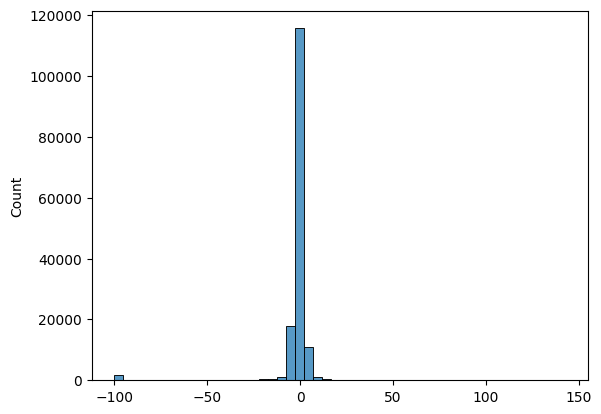

In [60]:
sns.histplot([np.around(ex[2], 2) for ex in lunar_buffer], bins=50)

In [61]:
lunar_env.tiles

In [62]:
lunar_eval_X, lunar_eval_y = proj_obs_to_rwest_vec(lunar_buffer, sample_size=50_000)

In [63]:
lunar_eval_X.shape, lunar_eval_y.shape

((50000, 24), (50000,))

In [64]:
lunar_eval_y

array([ 1.72669864, -0.26455082, -0.58815715, ..., -0.8823373 ,
        0.69653596,  1.1522805 ])

In [65]:
np.matmul(lunar_eval_X, lunar_sol)

array([ 0.46650723, -0.24652772,  0.31998148, ...,  0.17905872,
       -0.27274123, -0.07427755])

In [66]:
rmse(
    v_pred=np.matmul(lunar_eval_X, lunar_sol), 
    v_true=lunar_eval_y,
    axis=0
)

10.965940041286553

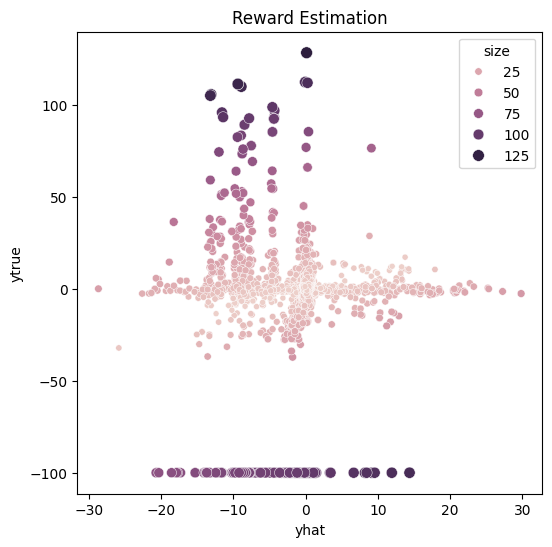

In [67]:
rwe_scatterplot(
    v_pred=np.matmul(lunar_eval_X, lunar_sol), 
    v_true=lunar_eval_y
)

In [68]:
def tmp():
    env = gym.make("LunarLander-v3")

    samples = []
    for i in range(10000):
        obs, _ = env.reset()
        for j in range(100):
            observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
            done = terminated or truncated
            samples.append(
                {
                    "reward": reward,
                    "step": j
                }
            )
            if done:
                break
    return pd.DataFrame(samples)
        

In [69]:
df_tmp = tmp()

In [70]:
df_tmp

,reward,step
0,0.911619,0
1,-2.841844,1
2,0.495464,2
3,1.121025,3
4,0.235316,4
...,...,...
867399,0.159576,82
867400,-2.157005,83
867401,7.715701,84
867402,6.726636,85


In [71]:
df_tmp["type"] = df_tmp["step"].apply(lambda step: "First" if step == 0 else "Other")

In [72]:
df_tmp

,reward,step,type
0,0.911619,0,First
1,-2.841844,1,Other
2,0.495464,2,Other
3,1.121025,3,Other
4,0.235316,4,Other
...,...,...,...
867399,0.159576,82,Other
867400,-2.157005,83,Other
867401,7.715701,84,Other
867402,6.726636,85,Other


In [73]:
df_tmp[df_tmp["step"] == 0]

,reward,step,type
0,0.911619,0,First
100,-0.480373,0,First
200,0.042483,0,First
300,1.187525,0,First
366,-0.131413,0,First
...,...,...,...
866925,0.482958,0,First
867024,0.414632,0,First
867124,-1.635789,0,First
867217,1.655509,0,First


/home/guilherme/code/research-phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/guilherme/code/research-phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/guilherme/code/research-phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warnin

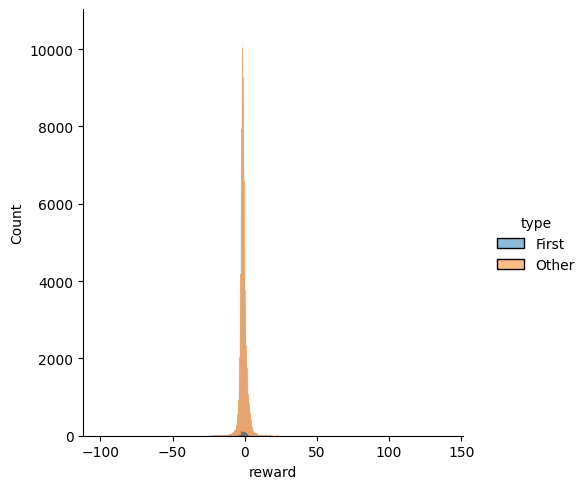

In [74]:
sns.displot(df_tmp, x="reward", hue="type")

In [75]:
def st_rw():
    env = LLObsPreproc(gym.make("LunarLander-v3"))
    states = []
    rewards = []
    for i in range(10_000):
        obs, _ = env.reset()
        for j in range(20):
            # reward is based on the next state?
            next_obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
            if j != 0:
                states.append(obs)
                rewards.append(reward)
            
            done = terminated or truncated
            obs = next_obs
            if done:
                break
    return np.array(states), np.array(rewards)

In [76]:
states, rewards = st_rw()

In [77]:
states

array([[ 2.4343729e-03, -1.5743375e-03,  7.5774575e-03,  2.6331544e-03,
         0.0000000e+00,  0.0000000e+00],
       [ 2.5492907e-03, -1.1633575e-02,  8.2365451e-03,  1.3182163e-02,
         0.0000000e+00,  0.0000000e+00],
       [ 2.9730797e-03,  9.5332265e-03,  7.9879649e-03, -4.9722046e-03,
         0.0000000e+00,  0.0000000e+00],
       ...,
       [-1.0128856e-02,  2.6517421e-02,  8.3035044e-03, -3.7074089e-05,
         0.0000000e+00,  0.0000000e+00],
       [-1.0723233e-02,  2.5336593e-02,  1.0711141e-02,  4.8156500e-02,
         0.0000000e+00,  0.0000000e+00],
       [-1.1316419e-02,  2.7074546e-02,  8.8694543e-03, -3.6836848e-02,
         0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [78]:
rewards

array([-0.21523145, -2.34941875, -3.60535845, ..., -2.5624516 ,
       -2.49275579, -2.57702459])

In [79]:
x = np.array([-100, -100, -100, 0, 10, 10])

In [80]:
yhat = np.dot(states, x)

In [81]:
yhat, rewards

(array([-0.84374929,  0.08477392, -2.04942711, ..., -2.46920697,
        -2.53245011, -2.46275812]),
 array([-0.21523145, -2.34941875, -3.60535845, ..., -2.5624516 ,
        -2.49275579, -2.57702459]))

In [82]:
rmse(yhat, rewards, axis=0)

2.110411790416094

In [83]:
np.dot(states[1], x), rewards[0]

(0.08477391675114632, -0.21523145308954666)

In [84]:
np.dot(states[2], x), rewards[1]

(-2.049427106976509, -2.3494187453485322)

In [85]:
np.dot(states[3], x), rewards[2]

(-3.3053502440452576, -3.6053584510639096)

In [86]:
np.dot(states[5], x), rewards[4]

(-0.7013279944658279, -0.7013228409635417)

In [87]:
rmse(np.dot(states[1:,:], x), rewards[:-1], axis=0)

0.5505038888064687

LunarLander rewards are:
  - Conditioned on the current reward, state changes, and action
  - Non-linear, using sqrt for certain elements of state

Even if we could simply modify the exposed state to, so to only leave the remaining linear transformations, it would still be complex to model since the reward (1) still requires subtracting values that are conditioned on hidden conditions and (2) the values for the initial state (for which there is no previous state) would remain difficult to model with a linear function.

Conclusively, this environment can be excluded from these experiments, is it does not align with the set of problems we aim at solving.

## Conclusions


  - Where we have single rewards or a linear mapping between discrete states and rewards, tiling seems to work quite well.
  - The performance when rewards for different states are different seems to be a factor not just the tiling, but the sample used for estimation - it needs to be representative of the environment space.